#### Wiktoria Szymańska 140790

### Laboratorium KCK
# **Projekt**: Detekcja tablic rejestracyjnych na obrazie

Projekt polegał na stworzeniu systemu do detekcji tablic rejestracyjnych na zdjęciach pojazdów. Celem projektu było wykorzystanie głębokiego uczenia w celu nauczenia modelu rozpoznawania i lokalizowania tablic rejestracyjnych na obrazach.

Do wykonania projektu wykorzystano platformę Kaggle, gdzie można wykorzystać gotowe zbiory danych oraz jest możliwość uruchomienia kernela na GPU w celu przyspieszenia przetwarzania.

Wybrany zbiór wejściowy składał się z 237 obrazów pojazdów, gdzie każdy obraz był opisany w pliku "license.csv" współrzędnymi obszaru zawierającego tablicę rejestracyjną.

Źródło zbioru danych:
https://www.kaggle.com/datasets/aritrag/license

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

##### Przygotowanie danych
Wczytanie obrazów pojazdów oraz ich etykiet (współrzędne tablic rejestracyjnych). Następnie przetworzenie obrazów poprzez zmniejszenie rozmiaru i normalizację wartości pikseli.

Error loading image: ../input/license/Cars/car107.jpg


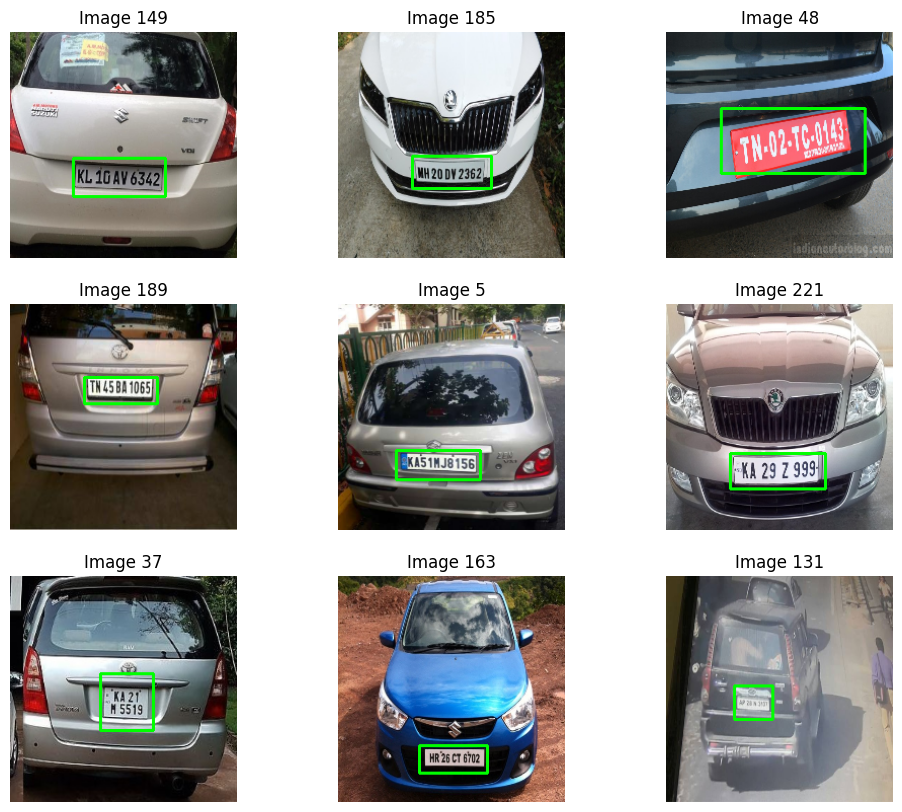

In [25]:
# Load dataset
data = pd.read_csv("/kaggle/input/license/license.csv", skiprows=1, names=['image_name', 'top_x', 'top_y', 'bottom_x', 'bottom_y'])

images = []
annotations = []

for index, row in data.iterrows():
    img = cv2.imread(row['image_name'])
    if img is None:
        print("Error loading image:", row['image_name'])
        continue  # Skip image if unable to load
    
    # Resize image
    resized_img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0, 1]
    normalized_img = resized_img / 255.0
    
    images.append(normalized_img)
    
    # Adjust bounding box coordinates for resizing
    top_x = int(row['top_x'] * resized_img.shape[1])
    top_y = int(row['top_y'] * resized_img.shape[0])
    bottom_x = int(row['bottom_x'] * resized_img.shape[1])
    bottom_y = int(row['bottom_y'] * resized_img.shape[0])
    
    annotations.append([top_x, top_y, bottom_x, bottom_y])

images = np.array(images)
annotations = np.array(annotations)

# Choose random example images
indices = np.random.choice(len(images), 9, replace=False)
saved_indices = indices.copy()

# Display the images with annotations
plt.figure(figsize=(12, 10))
for i, index in enumerate(indices):
    plt.subplot(3, 3, i+1)
    selected_image = images[index].copy()
    annotation = annotations[index]
    top_x, top_y, bottom_x, bottom_y = annotation
    cv2.rectangle(selected_image, (top_x, top_y), (bottom_x, bottom_y), (0, 255, 0), 2)
    rgb_image = cv2.cvtColor(selected_image.astype(np.float32), cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.title(f"Image {index}")
    plt.axis('off')
plt.show()

##### Projektowanie modelu
Zdefiniowanie architektury modelu głębokiego uczenia, który będzie wykorzystywany do detekcji tablic rejestracyjnych. Wybrano konwolucyjne sieci neuronowe (CNN) ze względu na ich skuteczność w zadaniach detekcji obiektów.

In [26]:
# Define the CNN architecture
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Split the data into training and validation sets
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2)

##### Trening modelu
Podział danych na zbiór treningowy i walidacyjny, a następnie trening modelu na danych treningowych. Wykorzystano algorytm optymalizacji Adam oraz funkcję straty *mean square error* (MSE).

In [27]:
# Check if the model file already exists
model_path = "/kaggle/working/model.h5"

if os.path.exists(model_path):
    model = load_model(model_path)
    print("Model loaded successfully!")
else:
    # Train the model
    history = model.fit(train_images, train_annotations, epochs=10, batch_size=32, validation_data=(val_images, val_annotations))

    # Save the model
    model.save(model_path)
    print("Model trained and saved successfully!")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step - accuracy: 0.4271 - loss: 10923.0537 - val_accuracy: 0.4792 - val_loss: 3532.2781
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4636 - loss: 3167.3726 - val_accuracy: 0.5208 - val_loss: 2185.3413
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5232 - loss: 2130.2197 - val_accuracy: 0.6042 - val_loss: 2195.5066
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4978 - loss: 1977.6271 - val_accuracy: 0.4792 - val_loss: 2240.8184
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4691 - loss: 1857.6624 - val_accuracy: 0.5208 - val_loss: 1811.8716
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6210 - loss: 1555.8247 - val_accuracy: 0.5000 - val_loss: 1744.2673
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4616 - loss: 1543.6260 - val_accuracy: 0.6042 - val_loss: 1486.6206
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6881 - loss: 1442.

##### Ocena modelu
Ocena wydajności modelu na zbiorze walidacyjnym poprzez obliczenie straty i dokładności modelu.

In [28]:
# Evaluate the model
loss, accuracy = model.evaluate(val_images, val_annotations)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6250 - loss: 1263.6389
Validation Loss: 1350.6083984375
Validation Accuracy: 0.625


##### Wizualizacja wyników

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


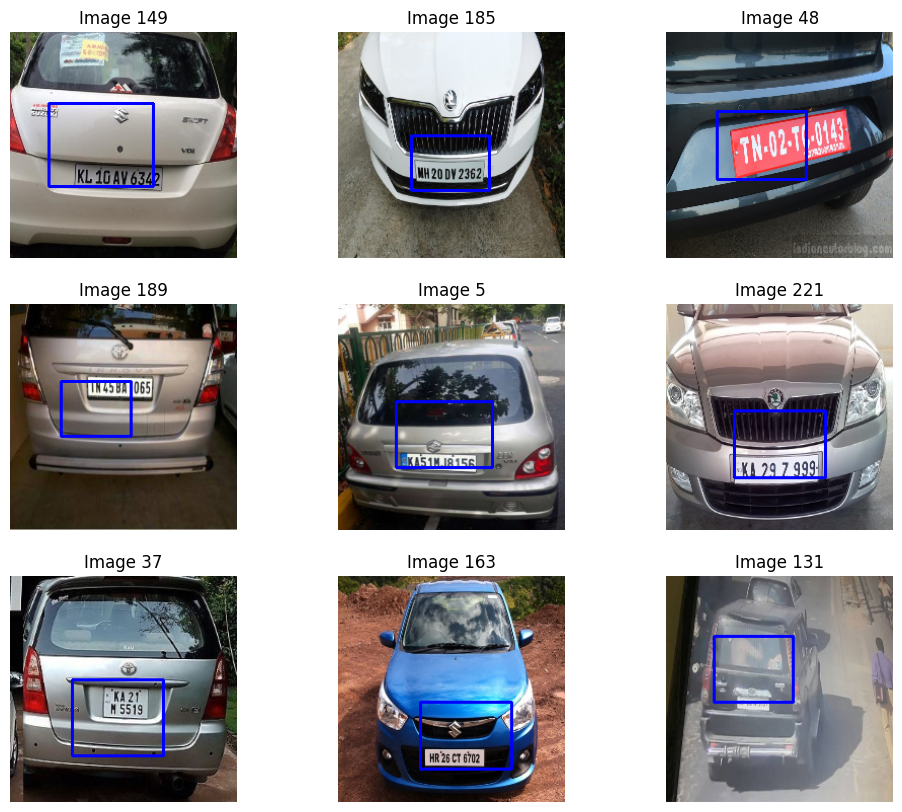

In [29]:
# Visualize predicted images
plt.figure(figsize=(12, 10))
for i, index in enumerate(saved_indices):
    plt.subplot(3, 3, i+1)
    selected_image = images[index]
    predicted_bbox = model.predict(np.expand_dims(selected_image, axis=0))[0]
    top_x_pred, top_y_pred, bottom_x_pred, bottom_y_pred = predicted_bbox
    cv2.rectangle(selected_image, (int(top_x_pred), int(top_y_pred)), (int(bottom_x_pred), int(bottom_y_pred)), (255, 0, 0), 2)
    rgb_image = cv2.cvtColor(selected_image.astype(np.float32), cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.title(f"Image {index}")
    plt.axis('off')
plt.show()


In [23]:
# # Deleting all output files
# files = os.listdir("/kaggle/working/")
# for file in files:
#     if not os.path.isdir(file):
#         file_path = os.path.join("/kaggle/working/", file)
#         os.remove(file_path)